# DC Normalized AC Plots
Plotting DC normalized AC vs. SDD for both wavelengths for different a) fetal depth and b) fetal saturation

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization, generate_differential_data_loaders, DifferentialCombinationDataset
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp, interpolate_exp_transform
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models.custom_models import SplitChannelCNN, PerceptronReLU
from inverse_modelling_tfo.features.build_features import create_ratio, create_spatial_intensity
import seaborn as sns

plt.style.use('seaborn')
# plt.rcParams['figure.dpi'] = 150    # Smaller plot
plt.rcParams['figure.dpi'] = 700    # Paper-ready plots

In [30]:
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity_low_conc2.pkl')
equidistance_detector_normalization(data)
AMNIOTIC_FLUID_THICKNESS = 1.0
data['Fetal Depth'] = data["Maternal Wall Thickness"] + data['Uterus Thickness'] + AMNIOTIC_FLUID_THICKNESS
data.drop(columns=['Uterus Thickness', 'Maternal Wall Thickness'], inplace=True)

In [31]:
# We don't care about Maternal Saturation or Hb Concentration
MATERNAL_Hb = 12.0
MATERNAL_Sat = 1.0
filtered_data = data[(data['Maternal Hb Concentration'] == MATERNAL_Hb) & (data['Maternal Saturation'] == MATERNAL_Sat)].copy()
filtered_data.drop(columns=["Maternal Hb Concentration", "Maternal Saturation"], inplace=True)
filtered_data.head()

,SDD,Intensity,Wave Int,Fetal Hb Concentration,Fetal Saturation,Fetal Depth
2000,10,1.311057e-05,1.0,0.11,0.1,12.0
2001,14,1.333901e-07,1.0,0.11,0.1,12.0
2002,19,1.919294e-09,1.0,0.11,0.1,12.0
2003,23,2.849659e-10,1.0,0.11,0.1,12.0
2004,28,1.015898e-10,1.0,0.11,0.1,12.0


In [32]:
# Pulsation Levels
FETAL_Hb_LOW = 0.11
FETAL_Hb_HIGH = 0.17
data_hb_low = filtered_data[filtered_data['Fetal Hb Concentration'] == FETAL_Hb_LOW].copy().drop(columns='Fetal Hb Concentration').reset_index(drop=True)
data_hb_high = filtered_data[filtered_data['Fetal Hb Concentration'] == FETAL_Hb_HIGH].copy().drop(columns='Fetal Hb Concentration').reset_index(drop=True)

In [33]:
# Calculating DC & AC
dc = data_hb_high['Intensity']
ac = data_hb_low['Intensity'] - data_hb_high['Intensity']
dc_norm_ac = ac / dc

df = data_hb_low.copy()
df['DNA'] = dc_norm_ac
df.drop(columns='Intensity', inplace=True)
df.head()

,SDD,Wave Int,Fetal Saturation,Fetal Depth,DNA
0,10,1.0,0.1,12.0,0.000016
1,14,1.0,0.1,12.0,0.000984
2,19,1.0,0.1,12.0,0.036313
3,23,1.0,0.1,12.0,0.142954
4,28,1.0,0.1,12.0,0.222759


## Effects of Depth
Plotting DC normalized AC for both wavelengths for multiple-fetal depth

In [36]:
df['Fetal Depth'].unique()

array([12.,  8., 10., 20., 18., 16., 22., 14.])

<AxesSubplot:xlabel='SDD', ylabel='DNA'>

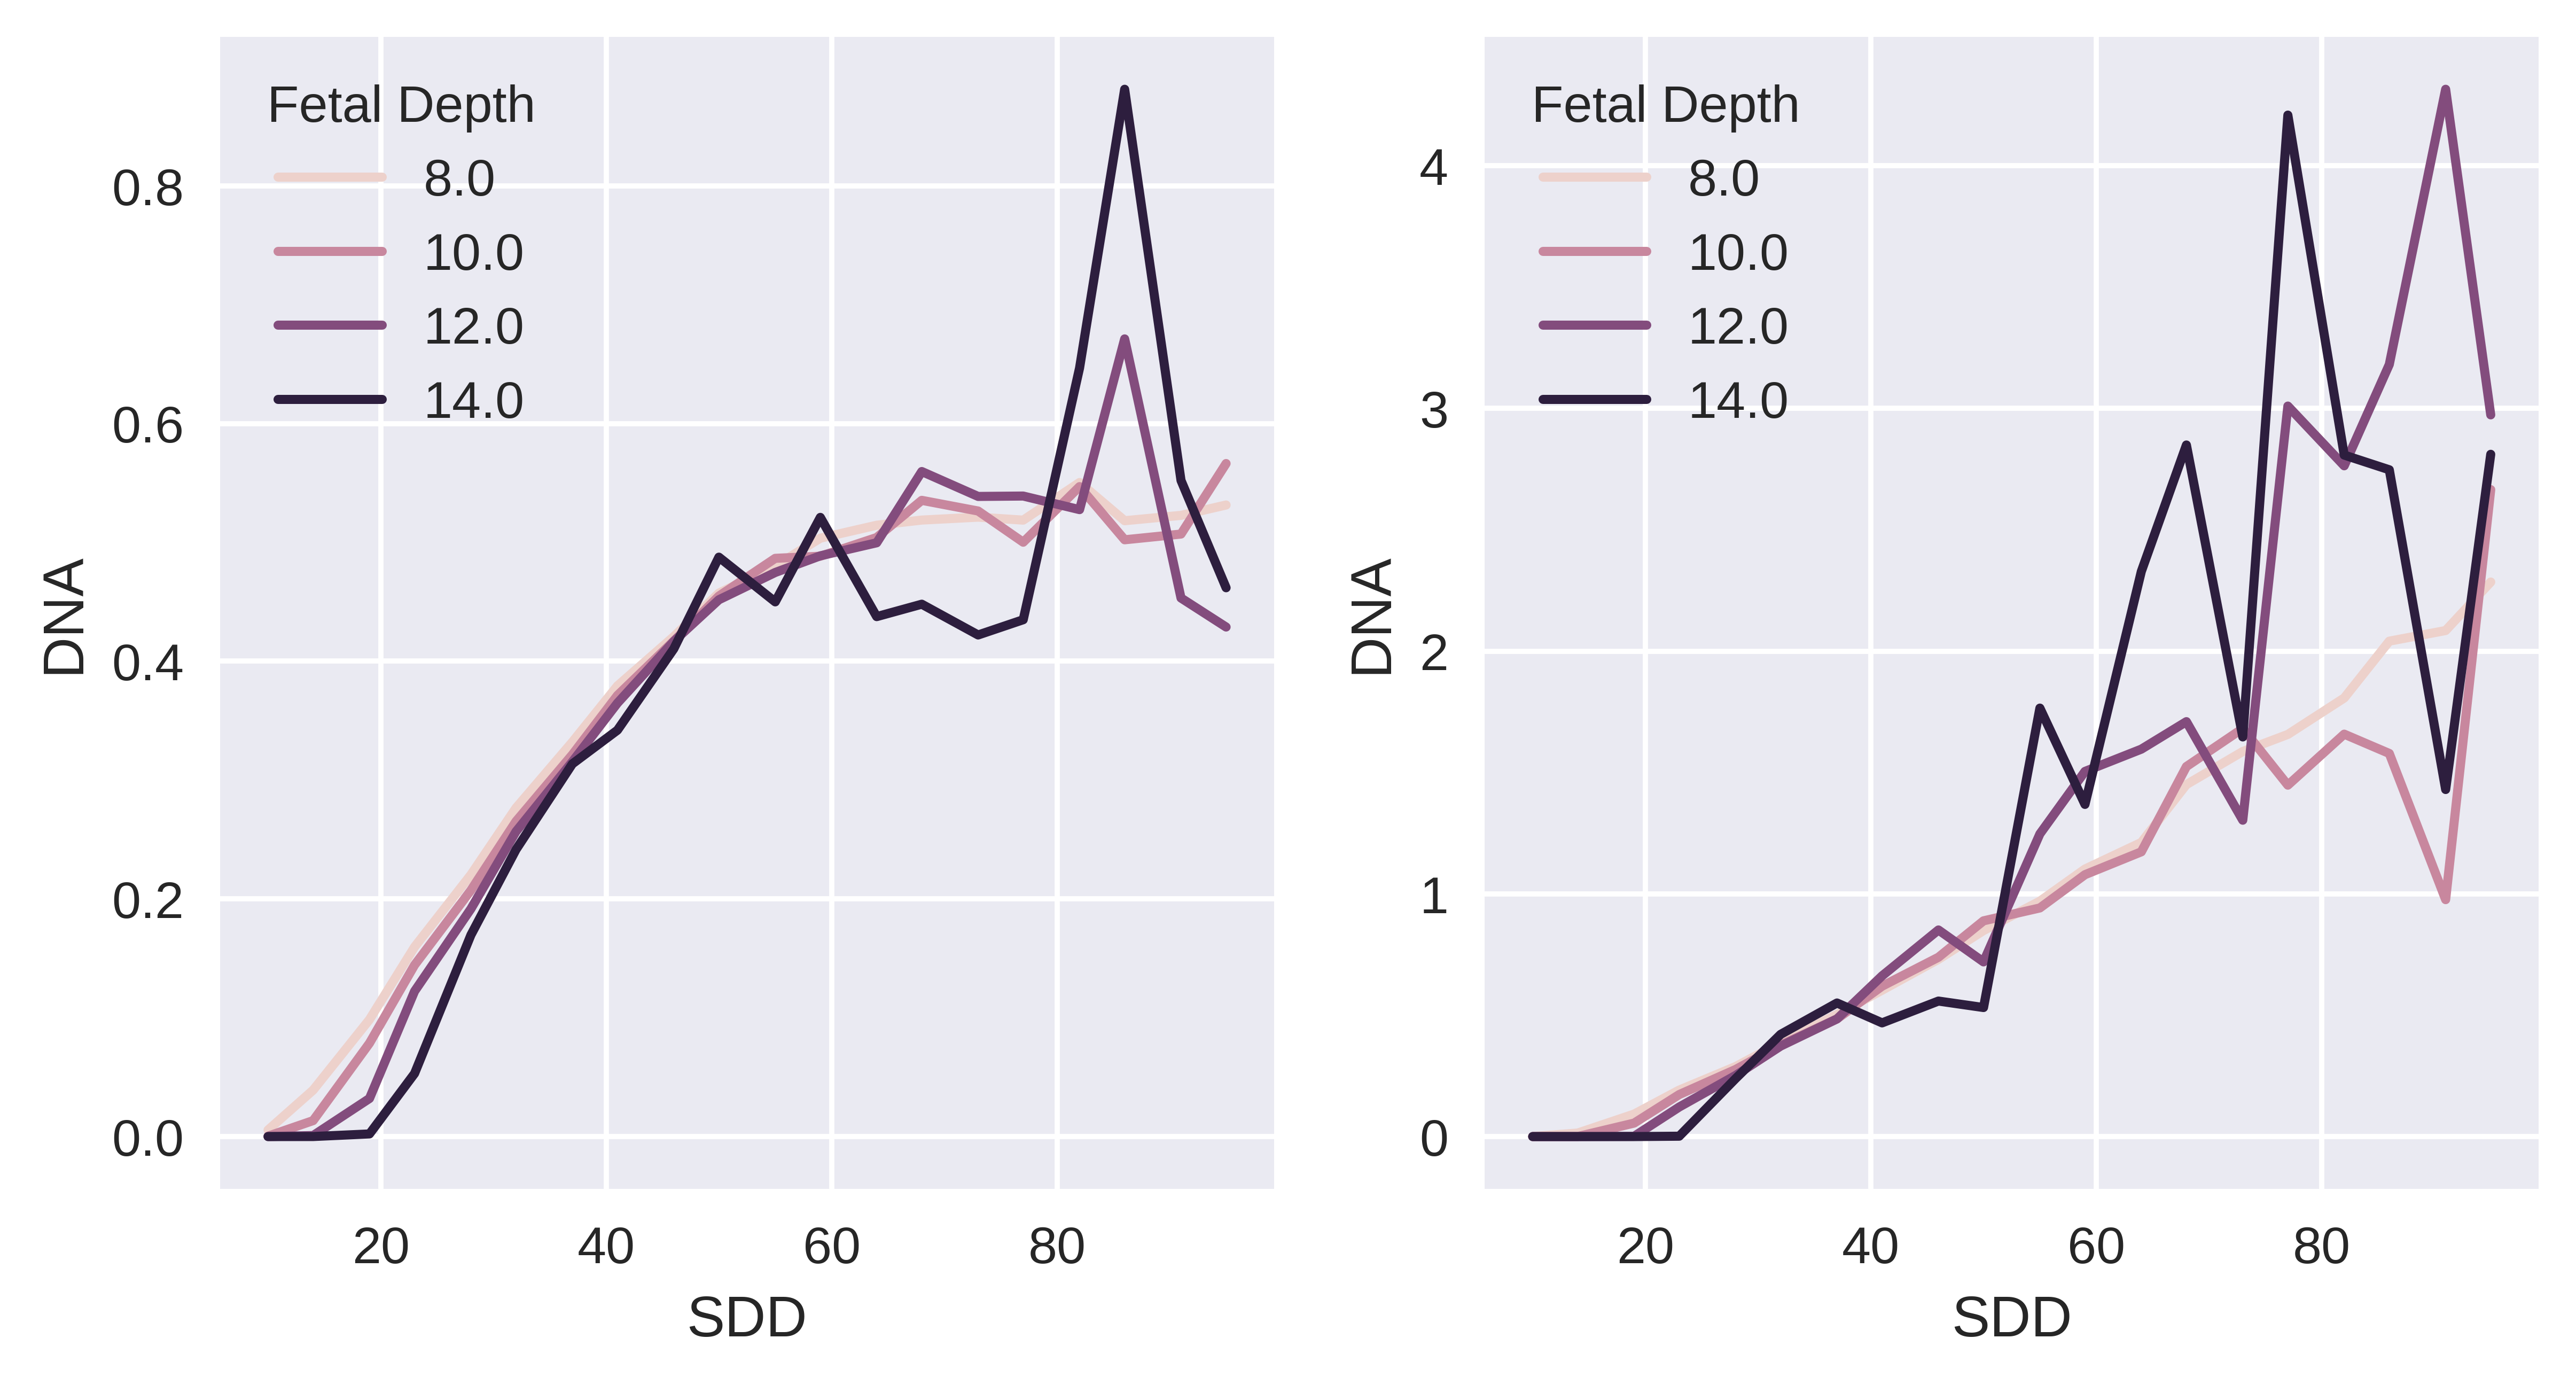

In [53]:
FIXED_FETAL_SAT = 0.6
filtered_df_wv1 = df[(df['Fetal Saturation'] == FIXED_FETAL_SAT) & (df['Wave Int'] == 1.0) & (df['Fetal Depth'] <= 14.0)].copy()
filtered_df_wv2 = df[(df['Fetal Saturation'] == FIXED_FETAL_SAT) & (df['Wave Int'] == 2.0) & (df['Fetal Depth'] <= 14.0)].copy()

filtered_df_wv1.reset_index(drop=True, inplace=True)
filtered_df_wv2.reset_index(drop=True, inplace=True)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.lineplot(filtered_df_wv1, x='SDD', y='DNA', hue='Fetal Depth')
# sns.lineplot(filtered_df_wv1, x='SDD', y='DNA')
plt.subplot(1, 2, 2)
sns.lineplot(filtered_df_wv2, x='SDD', y='DNA', hue='Fetal Depth')
# sns.lineplot(filtered_df_wv2, x='SDD', y='DNA')

In [45]:
filtered_df_wv1

,SDD,Wave Int,Fetal Saturation,Fetal Depth,DNA
581,14,1.0,0.6,8.0,0.039092
582,19,1.0,0.6,8.0,0.098455
583,23,1.0,0.6,8.0,0.159543
584,28,1.0,0.6,8.0,0.220321
585,32,1.0,0.6,8.0,0.276471
...,...,...,...,...,...
1095,77,1.0,0.6,22.0,3.568079
1096,82,1.0,0.6,22.0,1.281004
1097,86,1.0,0.6,22.0,0.458385
1089,50,1.0,0.6,22.0,0.356500
